# Backtesting (Mikasa)

In [6]:
import keras

import sys

sys.path.append('.')

import os
import datetime
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

np.random.seed(7)

from mikasa.strategy import Strategy
from mikasa.event import SignalEvent, OrderEvent
from mikasa.backtest import Backtest
from mikasa.data import HistoricCSVDataHandler
from mikasa.portfolio import NaivePortfolio
from mikasa.execution import SimulatedExecutionHandler

from sklearn.preprocessing import StandardScaler

In [7]:
class NaiveStopPortfolio(NaivePortfolio):
    TILT = 0.001

    def generate_naive_order(self, signal):
        order = None

        mkt_quantity = 1000.0
        cur_quantity = self.current_positions[signal.symbol]
        order_type = 'MKT'

        price = self.bars.get_latest_bars(signal.symbol)[0].close

        if signal.signal_type == 'LONG' and cur_quantity == 0:
            price *= (1.0 + self.TILT)
            order = OrderEvent(signal.symbol, order_type, mkt_quantity, 'BUY', price)
        if signal.signal_type == 'SHORT' and cur_quantity == 0:
            price *= (1.0 - self.TILT)
            order = OrderEvent(signal.symbol, order_type, mkt_quantity, 'SELL', price)

        if signal.signal_type == 'EXIT':
            if cur_quantity > 0:
                price *= (1.0 - self.TILT)
                order = OrderEvent(signal.symbol, order_type, abs(cur_quantity), 'SELL', price)
            if cur_quantity < 0:
                price *= (1.0 + self.TILT)
                order = OrderEvent(signal.symbol, order_type, abs(cur_quantity), 'BUY', price)

        return order

In [11]:
class PredictStrategy(Strategy):
    def __init__(self, bars, events):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events

        self.lag = 12

        csv_dir = './datasets/5min/'

        df = pd.read_csv(os.path.join(csv_dir, symbol_list[0] + '.csv'))
        for lag in range(1, self.lag + 1):
            df['close-' + str(lag)] = df['close'] - df.shift(lag)['close']
        df.dropna(inplace=True)

        self.close_fields = ['close-{}'.format(i + 1) for i in range(self.lag)]

        df['up'] = df['close'] < df.shift(-1)['close']

        self.scaler = StandardScaler()
        X = df[self.close_fields].values
        self.scaler.fit(X)

        self.model = keras.models.load_model('model_5min_btc_eth.h5')

    def calculate_signals(self, event):
        if event.type == 'MARKET':
            dt = self.bars.get_latest_bars_values(self.symbol_list[0], 'datetime')[0]

            X = self.bars.get_latest_bars_values(self.symbol_list[0], 'close', N=self.lag + 1)
            if len(X) == self.lag + 1:
                df = pd.DataFrame(X, columns=['close'])
                for lag in range(1, self.lag + 1):
                    df['close-' + str(lag)] = df['close'] - df.shift(lag)['close']
                df.dropna(inplace=True)
                X = df[self.close_fields].values
                X = self.scaler.transform(X)
                prediction = self.model.predict(X)[0]
                if prediction[1] > 0.7:
                    signal = SignalEvent(1, self.symbol_list[0], dt, 'LONG', 1.0)
                    self.events.put(signal)
                if prediction[0] > 0.7:
                    signal = SignalEvent(1, self.symbol_list[0], dt, 'EXIT', 1.0)
                    self.events.put(signal)

In [12]:
csv_dir = './datasets/5min/'
symbol_list = ['BTC_ETH', ]
initial_capital = 1.0
heartbeat = 0.0
start_date = datetime(2016, 9, 9, 0, 0, 1)

backtest = Backtest(
        csv_dir,
        symbol_list,
        initial_capital,
        heartbeat,
        start_date,
        HistoricCSVDataHandler,
        SimulatedExecutionHandler,
        NaiveStopPortfolio,
        PredictStrategy,
        fields=['open', 'high', 'low', 'close']
)
backtest.simulate_trading()

                      BTC_ETH       cash  commission      total   returns  \
datetime                                                                    
2017-09-18 15:40:00   0.00000  34.278705   -0.066425  34.278705  0.000000   
2017-09-18 15:45:00   0.00000  34.278705   -0.066425  34.278705  0.000000   
2017-09-18 15:50:00   0.00000  34.278705   -0.066425  34.278705  0.000000   
2017-09-18 15:55:00   0.00000  34.278705   -0.066425  34.278705  0.000000   
2017-09-18 16:00:00   0.00000  34.278705   -0.066425  34.278705  0.000000   
2017-09-18 16:05:00   0.00000  34.278705   -0.066425  34.278705  0.000000   
2017-09-18 16:10:00  73.33666 -39.268637    0.080377  34.068023 -0.006146   
2017-09-18 16:15:00   0.00000  34.214697   -0.066297  34.214697  0.004305   
2017-09-18 16:20:00   0.00000  34.214697   -0.066297  34.214697  0.000000   
2017-09-18 16:20:00  73.33702 -39.268997    0.080377  34.068023 -0.004287   

                     equity_curve  
datetime                           
201

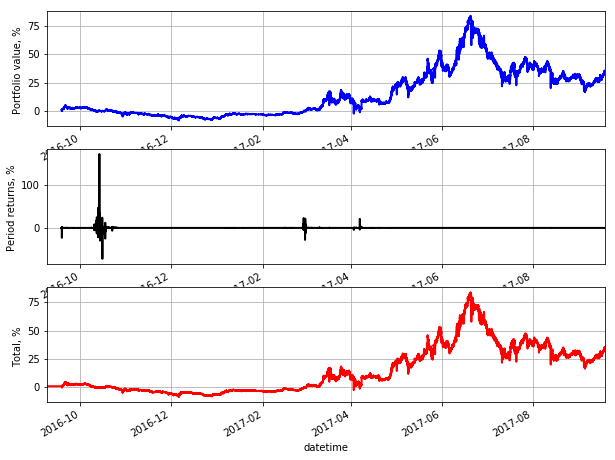

In [13]:
backtest.plot()